# Evaluating annotations of understatements



In [1]:
# Install necessary libraries
import sys
libraries = ["polars", "openai", "instructor", "pydantic", "statsmodels", "os"]

for library in libraries:
    try:
        __import__(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} not found, installing...")
        !{sys.executable} -m pip install {library}

polars is already installed.
openai is already installed.
instructor is already installed.
pydantic is already installed.
statsmodels is already installed.
os is already installed.


In [3]:
from pydantic import BaseModel
from typing_extensions import Literal
from openai import OpenAI
import polars as pl
import instructor
import statsmodels
import os
import dotenv
import json
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import pandas as pd # statsmodels expects a pandas DataFrame

In [4]:
# Set your key and a model from https://platform.openai.com/docs/models/continuous-model-upgrades
chosen_model = "gpt-4-turbo"
dotenv.load_dotenv('.env')
key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key=key)

## Part 1: Annotating understatements with LLMs

### Step 1: Import and preprocess data

The sentences for the annotation task are in a Google Sheet and exported as TSV. 

To annotate the sentences:
1. Open the TSV files
2. Extract the sentences from the TSV file

In [5]:
# Open the TSV file.
with open('datasets/annotation-task.tsv', 'r') as file:
    text = file.read()

# Extract the sentences from the TSV file.
rows = text.split('\n')
data = [row.split('\t') for row in rows]
unlabeled_dataset = data[1:]

### Step 2: Test the understatement annotation task

Let's test a simple prompt for the understatement annotation task.

In the prompt, we present a phrase in context and ask for four labels:

1. Whether the sentence is an understatement (Yes/No)
2. *It's confidence in the label (1-3)
3. If it thinks the phrase is an understatement, whether its litoses or meiosis (Litotes/Meiosis)
4. If it thinks the phrase is an understatement, the pragmatic function of the understatement (Mocking/Humorous/Tempering)

The phrase in context is surrounded with a pair of square brackets.


In [15]:
first_example = unlabeled_dataset[60][1]
prompt = f"""Read the following text and answer four questions: 

---START OF TEXT---
{first_example}
---END OF TEXT---

Question 1: Is the phrase in square brackets an understatement?
Question 2: On a scale from 1 to 3, how confident are you in your answer to question 1?
Question 3: If you think the phrase is an understatement, is it type litoses or meiosis?
Question 4: If you think the phrase is an understatement, is the pragmatic function of the understatement mocking, humorous, or tempering?"""

print(prompt)

Read the following text and answer four questions: 

---START OF TEXT---
“Do you know, my friends,” said Michel Ardan, “that if one of us had succumbed to the shock consequent on departure, we should have had a great deal of trouble to bury him? What am I saying? to etherize him, as here ether takes the place of earth. You see the accusing body would have followed us into space like a remorse.”  “[That would have been sad],” said Nicholl.
---END OF TEXT---

Question 1: Is the phrase in square brackets an understatement?
Question 2: On a scale from 1 to 3, how confident are you in your answer to question 1?
Question 3: If you think the phrase is an understatement, is it type litoses or meiosis?
Question 4: If you think the phrase is an understatement, is the pragmatic function of the understatement mocking, humorous, or tempering?


Next, we create a helper function to pass the prompt to the LLM:

In [16]:
# Here's how we interact with the model
def annotate(chosen_prompt):
    resp = client.chat.completions.create(
        model=chosen_model, 
        messages=[
            {"role": "user", 
            "content": chosen_prompt},
        ],
        temperature=1,
        )
    annotation = resp.choices[0].message.content
    return annotation

Let's test the prompt with our first sentence:

In [17]:
print(annotate(prompt))

Answer 1: Yes, the phrase in square brackets, "That would have been sad," is an understatement.

Answer 2: I am 3 (very confident) in my answer to question 1. The expression "That would have been sad" minimizes the emotional impact and the unusual, eerie scenario described, making it a clear understatement.

Answer 3: The understatement is an example of meiosis. Meiosis is a type of understatement that deliberately understates or de-emphasizes the importance of something. In this case, describing the potential presence of an "accusing body" haunting them in space as merely "sad" significantly downplays the scenario.

Answer 4: The pragmatic function of the understatement in this context is likely humorous. The use of such a casual remark in the context of a bizarre and potentially horrifying situation can add a touch of irony and levity, suggesting that the speaker is using humor to deal with the concept of death and its consequences in a detached, unusual environment like space.


Done. While the model has replied to all four questions, we have two issues:

1. The model only annotated one sentence. We need to annotate **all** the sentences.
2. The model's answers are unstructured. We need to extract the answers and save them in a structured format.

Let's solve these issues one by one.

### Step 3: Annotate many texts (understatements)

If we iterate over all the sentences, we can annotate them one by one and save the annotations in a list called `annotations_list`.

In [10]:
annotations_list = []

for i, row in enumerate(unlabeled_dataset[:5], 1):
    
    prompt = f"""Read the following text and answer four questions: 

---START OF TEXT---
{row[1]}
---END OF TEXT---

Question 1: Is the phrase in square brackets an understatement?
Question 2: On a scale from 1 to 3, how confident are you in your answer to question 1?
Question 3: If you think the phrase in square brackets is an understatement, is it type litoses or meiosis?
Question 4: If you think the phrase in square brackets is an understatement, is the pragmatic function of the understatement mocking, humorous, or tempering?"""
    
    print(f" --- ANNOTATING TEXT {i} ---")
    annotation = annotate(prompt)
    print(annotation)
    print("\n")

    # store the annotations in the dictionary
    annotations_list.append(annotation)

 --- ANNOTATING TEXT 1 ---
Question 1: Yes, the phrase in square brackets is an understatement.

Question 2: I am 3 (very confident) in my answer to question 1.

Question 3: The phrase in square brackets is a type of meiosis. This is because meiosis involves understating a situation or an element to subtly highlight its opposite, usually extreme, characteristic. In this context, Mrs. Allen's description of merely "[dressing] up a little" distinctly underplays the extravagance and grandeur of her highly elaborate and noticeable gown.

Question 4: The pragmatic function of the understatement is humorous. By significantly downplaying the effort and lavishness of her appearance, Mrs. Allen highlights the contrast between her words and her actual appearance, eliciting amusement from the audience and possibly from those hearing or reading about the scene. This light-hearted self-deprecation intentionally adds a layer of wit to her grand entrance.


 --- ANNOTATING TEXT 2 ---
Answer 1: No, th

### Step 4: Annotating understatements with structured output

Now that we can run the prompt for all samples in the dataset, we need to extract the answers and save them in a structured format.

To do this, we first need to amend the prompt to elicit structured responses. We do this by commanding the model to respond with a JSON object only:

In [11]:
prompt = f"""Read the following text and answer four questions: 

---START OF TEXT---
{first_example}
---END OF TEXT---

Question 1: Is the phrase in square brackets an understatement?
Question 2: On a scale from 1 to 3, how confident are you in your answer to question 1?
Question 3: If you think the phrase in square brackets is an understatement, is it type litoses or meiosis?
Question 4: If you think the phrase in square brackets is an understatement, is the pragmatic function of the understatement mocking, humorous, or tempering?

Respond with a JSON object only. Do not return any other information."""

To ensure the LLMs responses adhere to a structured format, we need to define a data model.

All responses are then matched to the data model, ensuring uniform structure. 

We use `pydantic` to define a data model, named `Understatement` and with four attributes:

1. `is_understatement`: Whether the sentence is an understatement (Yes/No)
2. `confidence`: The model's confidence in the label (1-3)
3. `understatement_type`: If the phrase is an understatement, whether it's litotes or meiosis (Litotes/Meiosis)
4. `pragmatic_function`: If the phrase is an understatement, the pragmatic function of the understatement (Mocking/Humorous/Tempering)



In [21]:
class Understatement(BaseModel):
    """
    An understatement with its annotations.
    """
    is_understatement: bool
    confidence: Literal[1, 2, 3]
    understatement_type: Literal["litotes", "meiosis", None]
    pragmatic_function: Literal["mocking", "humorous", "tempering", None]

Next, we initialize a client for `instructor` to extract the answers from the LLM's output and validate them against the `Understatement` model:

In [22]:
client = instructor.patch(OpenAI(api_key=key), mode=instructor.Mode.MD_JSON)

Let's update our helper function to use the `instructor` client, and pass the `Understatement` model to validate the responses:

In [23]:
def annotate_structured(chosen_prompt):
    resp = client.chat.completions.create(
        model=chosen_model, 
        messages=[
            {"role": "user", 
            "content": chosen_prompt},
        ],
        temperature=1,
        response_model=Understatement,
        )
    return resp

Finally, let's use the updated helper function to get a structured `annotation`:

In [24]:
annotation = annotate_structured(prompt)
print(annotation)

is_understatement=True confidence=2 understatement_type='meiosis' pragmatic_function='humorous'


The result is an `Understatement` object, with four attributes, corresponding to the four labels assigned per sample. 

These labels are chosen from closed sets of labels, of boolean (`is_understatement`), categorical (`understatement_type` and `pragmatic_function`), and ordinal (`confidence`) type.

### Step 5: Annotate many understatements with structured responses

Let's combine the steps above to annotate all the sentences in the dataset and save the annotations in a structured format.

In [48]:
annotated_data = []

for row in unlabeled_dataset:
    sample = {}
    
    prompt = f"""Read the following text and answer four questions: 

---START OF TEXT---
{row[1]}
---END OF TEXT---

Question 1: Is the phrase in square brackets an understatement?
Question 2: On a scale from 1 to 3, how confident are you in your answer to question 1?
Question 3: If you think the phrase in square brackets is an understatement, is it type litoses or meiosis?
Question 4: If you think the phrase in square brackets is an understatement, is the pragmatic function of the understatement mocking, humorous, or tempering?

Respond with a JSON object only."""
    
    try:
        annotation = annotate_structured(prompt)
    except Exception as e:
        # If the model fails to return a valid JSON object try again
        print(f"Error: {e}")
        annotation = annotate_structured(prompt)

    print(f" --- ANNOTATING TEXT {row[-1]} ---")
    print(annotation)

    sample["phrase"] = row[0]
    sample["full_text"] = row[1]
    sample["is_understatement"] = annotation.is_understatement
    sample["confidence"] = annotation.confidence
    sample["understatement_type"] = annotation.understatement_type
    sample["pragmatic_function"] = annotation.pragmatic_function
    annotated_data.append(sample)

 --- ANNOTATING TEXT  ---
is_understatement=True confidence=3 understatement_type='meiosis' pragmatic_function='humorous'
 --- ANNOTATING TEXT  ---
is_understatement=True confidence=3 understatement_type='litotes' pragmatic_function='mocking'
 --- ANNOTATING TEXT  ---
is_understatement=True confidence=3 understatement_type='meiosis' pragmatic_function='tempering'
 --- ANNOTATING TEXT  ---
is_understatement=True confidence=3 understatement_type='meiosis' pragmatic_function='tempering'


KeyboardInterrupt: 

Before we move on, let's save the annotations in a JSON file:

In [ ]:

with open('datasets/annotated-data-llm_baseline.json', 'w') as file:
    json.dump(annotated_data, file, indent=4)

Since we may want to rerun this notebook without having to reannotate everything through OpenAI again, we can simply load what we have saved:

In [6]:
with open('datasets/annotated-data-llm_baseline.json', 'r') as file:
    annotated_data = json.load(file)

Done. Let's inspect the results:

In [7]:
annotations_baseline_llm = annotated_data

for i, sentence in enumerate(annotations_baseline_llm, 1):
    print(f" --- ANNOTATED TEXT {i} ---")
    print(f'phrase: "{sentence["phrase"]}"')
    print(f"is_understatement: {sentence['is_understatement']}")
    print(f"confidence: {sentence['confidence']}")
    print(f"understatement_type: {sentence['understatement_type']}")
    print(f"pragmatic_function: {sentence['pragmatic_function']}")
    print("\n")

 --- ANNOTATED TEXT 1 ---
phrase: "I might have dressed up a little for the evening"
is_understatement: True
confidence: 3
understatement_type: meiosis
pragmatic_function: humorous


 --- ANNOTATED TEXT 2 ---
phrase: "not unremarkable"
is_understatement: True
confidence: 3
understatement_type: litotes
pragmatic_function: mocking


 --- ANNOTATED TEXT 3 ---
phrase: "took a tiny interest"
is_understatement: True
confidence: 3
understatement_type: meiosis
pragmatic_function: tempering


 --- ANNOTATED TEXT 4 ---
phrase: "Sometimes he's not quite the same, but we've done pretty good work."
is_understatement: True
confidence: 3
understatement_type: meiosis
pragmatic_function: tempering


 --- ANNOTATED TEXT 5 ---
phrase: "And probably twice as cursed"
is_understatement: True
confidence: 3
understatement_type: meiosis
pragmatic_function: humorous


 --- ANNOTATED TEXT 6 ---
phrase: "the stars themselves are hardly dead"
is_understatement: True
confidence: 3
understatement_type: meiosis
pragm

Now that we have successfully annotated all the sentences with an LLM, we can load the human annotations and compute Inter-Annotator Agreement metrics.

## Part 2: Load data from human annotators

Let's load the annotations from human annotators and normalize the labels to match the LLM annotations.

In [8]:
def extract_annotation_dict(row):
    """
    Extracts the data from a row of the TSV file.
    
    Args:
    - row: a list with the data of a row of the TSV file
    """

    sample = {}
    sample['phrase'] = row[0]
    sample['full_text'] = row[1]
    sample['is_understatement'] = row[2]
    sample['confidence'] = row[3]
    sample['pragmatic_function'] = row[4]
    sample['understatement_type'] = row[5]
    return sample

def normalize_annotation(sample):
    """
    Normalizes an annotation to match `Understatement` model.

    Args:
    - sample: a dictionary with the sample data
    """

    # Normalize `is_understatement`.
    if sample['is_understatement'] == "Yes":
        sample['is_understatement'] = True
    if sample['is_understatement'] == "No":
        sample['is_understatement'] = False
    if sample['is_understatement'] == "":
        sample['is_understatement'] = None

    # Normalize `confidence`.
    if sample['confidence'] == '1 - Not confident':
        sample['confidence'] = 1
    if sample['confidence'] == '2 - Somewhat confident':
        sample['confidence'] = 2
    if sample['confidence'] == '3 - Confident':
        sample['confidence'] = 3
    if sample['confidence'] == "":
        sample['confidence'] = None

    # Normalize `pragmatic_function`.
    if sample['pragmatic_function'] == "Tempering":
        sample['pragmatic_function'] = "tempering"
    if sample['pragmatic_function'] == "Humoristic":
        sample['pragmatic_function'] = "humorous"
    if sample['pragmatic_function'] == "Derisiv/mocking":
        sample['pragmatic_function'] = "mocking"
    if sample['pragmatic_function'] == "":
        sample['pragmatic_function'] = None

    # Normalize `understatement_type`.
    if sample['understatement_type'] == "Litotes (a negation of the opposite)":
        sample['understatement_type'] = "litotes"
    if sample['understatement_type'] == "Meiosis (a weaker expression)":
        sample['understatement_type'] = "meiosis"
    if sample['understatement_type'] == "":
        sample['understatement_type'] = None

    return sample

def get_annotations(path):
    """
    Extracts normalized annotations from a TSV file.

    Args:
    - path: the path to the TSV file
    """
    annotations = []

    # Open the TSV file, read the text, and split it into rows.
    with open(path, 'r') as file:
        text = file.read()
        rows = text.split('\n')
        data = [row.split('\t') for row in rows[1:]]
        
    # Extract the annotations from the rows, and normalize them.
    for row in data:
        sample = extract_annotation_dict(row)
        sample = normalize_annotation(sample)
        annotations.append(sample)

    return annotations

# Get annotations from four different annotators.
annotations_szabi = get_annotations('datasets/annotation-task-szabi.tsv')
annotations_antanas = get_annotations('datasets/annotation-task-antanas.tsv')
annotations_kris = get_annotations('datasets/annotation-task-kris.tsv')
annotations_bastiaan = get_annotations('datasets/annotation-task-bastiaan.tsv')

## Part 3: Calculate Inter-Annotator Agreement (IAA)

There are multiple metrics to calculate Inter-Annotator Agreement (IAA). 

We will start with the simplest metric, the **Observed Agreement**. Then, we will point out some of its limitations and introduce more advanced metrics.

### Step 1: Calculate Observed Agreement

The simplest metric for IAA is the observed agreement. It is the proportion of times the two annotators agree on the label.

Let's calculate the observed agreement for the `is_understatement` label between two annotators.

In [9]:
def calculate_observed_agreeement(annotations_a, annotations_b, silent=False):
    """
    Calculates the observed agreement between two annotators.
    """
    matches = 0
    for a, b in zip(annotations_a, annotations_b):
        if a['is_understatement'] == b['is_understatement']:
            matches += 1

    if not silent:
        print(f"Number of agreements:\t\t{matches}")
        print(f"Number of annotations:\t\t{len(annotations_szabi)}")
        print(f"Observed agreement (Po):\t{matches / len(annotations_szabi) * 100:.2f}% ({matches}/{len(annotations_szabi)})\n")

    return matches / len(annotations_szabi)

observed_agreement_antanas_szabi = calculate_observed_agreeement(annotations_antanas, annotations_szabi)

Number of agreements:		92
Number of annotations:		120
Observed agreement (Po):	76.67% (92/120)



While the observed agreement is easy to compute, it doesn't account for:

- **Agreement by chance**:  Agreement by chance is the probability that two annotators agree on a label just by chance. It is calculated as the product of the probability that each annotator assigns a label to a text.
- **Difficulty of the task**: If the task is easy, easy tasks will always have higher agreement than difficult tasks.
- **The number of labels**: If the task has many labels, the observed agreement will be lower than if the task has few labels.
- **The number of annotators**: If there are many annotators, the observed agreement will be lower than if there are few annotators.

To demonstrate this, let's calculate the observed agreement betweeen three annotators, instead of two:

In [10]:
matches = 0
for s, a, k, b, llm in zip(annotations_szabi, annotations_antanas, annotations_kris, annotations_bastiaan, annotations_baseline_llm):
    if a['is_understatement'] == s['is_understatement'] == k['is_understatement'] == b['is_understatement'] == llm['is_understatement']:
        matches += 1

print(f"Number of agreements:\t\t{matches}")
print(f"Number of annotations:\t\t{len(annotations_szabi)}")
print(f"Observed agreement (Po):\t{matches / len(annotations_szabi) * 100:.2f}% ({matches}/{len(annotations_szabi)})")

Number of agreements:		50
Number of annotations:		120
Observed agreement (Po):	41.67% (50/120)


While two annotators agreed on 92 out of 120 labels (76.67%), 5 annotators agreed on only 50 out of 120 labels (41.67%). 

> What does this drop in agreement say about the **quality** of the annotations?

### Step 2: Calculate Cohen's Kappa

Cohen's Kappa is a more advanced metric that accounts for chance agreement (Pe).

To calculate the chance agreement:

1. We need to calculate the probability that each annotator assigns a label to a text.
2. We multiply the probabilities to get the **chance agreement**.

Let's start by calculating the probability that each annotator assigns a label to a text:

In [1]:
true_count_szabi = 0
for s in annotations_szabi:
    if s['is_understatement'] == True:
        true_count_szabi += 1

print("Annotator 1:")
print(f"Phrases labeled as understatement:\t{true_count_szabi}")
print(f"Probability annotator 1 labels as True:\t{true_count_szabi / len(annotations_szabi) * 100:.2f}%\n")

true_count_antanas = 0
for s in annotations_antanas:
    if s['is_understatement'] == True:
        true_count_antanas += 1

print("Annotator 2:")
print(f"Phrases labeled as understatement:\t{true_count_antanas}")
print(f"Probability annotator 2 labels as True:\t{true_count_antanas / len(annotations_antanas) * 100:.2f}%\n")

true_count_kris = 0
for s in annotations_kris:
    if s['is_understatement'] == True:
        true_count_kris += 1

print("Annotator 3:")
print(f"Phrases labeled as understatement:\t{true_count_kris}")
print(f"Probability annotator 3 labels as True:\t{true_count_kris / len(annotations_kris) * 100:.2f}%\n")

true_count_bastiaan = 0
for s in annotations_bastiaan:
    if s['is_understatement'] == True:
        true_count_bastiaan += 1

print("Annotator 4:")
print(f"Phrases labeled as understatement:\t{true_count_bastiaan}")
print(f"Probability annotator 4 labels as True:\t{true_count_bastiaan / len(annotations_bastiaan) * 100:.2f}%\n")

true_count_llm = 0
for s in annotations_baseline_llm:
    if s['is_understatement'] == True:
        true_count_llm += 1

print("LLM Baseline:")
print(f"Phrases labeled as understatement:\t{true_count_llm}")
print(f"Probability LLM baseline labels as True:\t{true_count_llm / len(annotations_baseline_llm) * 100:.2f}%\n")

NameError: name 'annotations_szabi' is not defined

Next, let's define functions to calculate the chance agreement (Pe):

In [12]:
def calculate_chance_agreement(annotations_a, annotations_b):
    """
    Calculates the chance agreement between two annotators.
    """
    
    true_count_a = 0
    true_count_b = 0
    for a, b in zip(annotations_a, annotations_b):
        if a['is_understatement'] == True:
            true_count_a += 1
        if b['is_understatement'] == True:
            true_count_b += 1

    proportion_a = true_count_a / len(annotations_a)
    proportion_b = true_count_b / len(annotations_b)
    Pe = (proportion_a * proportion_b) + ((1 - proportion_a) * (1 - proportion_b))

    return Pe

Finally, let's define a function to calculate Cohen's Kappa, using the chance agreement (Pe) and the observed agreement (Po):

In [15]:
def calculate_kappa(annotations_a, annotations_b):
    """
    Calculates the Kappa coefficient for two annotators.

    Args:
    - annotations_a: annotations from the first annotator
    - annotations_b: annotations from the second annotator
    """

    # Calculate the chance agreement (Pe)
    Pe = calculate_chance_agreement(annotations_a, annotations_b)

    # Calculate the observed agreement (Po)
    Po = calculate_observed_agreeement(annotations_a, annotations_b, silent=True)

    # Calculate the Kappa coefficient.
    K = (Po - Pe) / (1 - Pe)
    return K

Let's calculate the Cohen's Kappa for the `is_understatement` label between all annotator pairs, and then calculate the average Cohen's Kappa:

In [17]:
K_szabi_antanas = calculate_kappa(annotations_szabi, annotations_antanas)
K_szabi_kris = calculate_kappa(annotations_kris, annotations_szabi)
K_szabi_bastiaan = calculate_kappa(annotations_bastiaan, annotations_szabi)
K_szabi_llm = calculate_kappa(annotations_baseline_llm, annotations_szabi)
K_antanas_kris = calculate_kappa(annotations_antanas, annotations_kris)
K_antanas_bastiaan = calculate_kappa(annotations_bastiaan, annotations_antanas)
K_antanas_llm = calculate_kappa(annotations_baseline_llm, annotations_antanas)
K_kris_bastiaan = calculate_kappa(annotations_bastiaan, annotations_kris)
K_kris_llm = calculate_kappa(annotations_baseline_llm, annotations_kris)
K_bastiaan_llm = calculate_kappa(annotations_baseline_llm, annotations_bastiaan)

# Print the Kappa coefficients in a table.
print("Kappa coefficients:")
print("Annotators\tSzabi\tAntanas\tKris\tBasti\tLLM Baseline")
print(f"Szabi\t\t---\t{K_szabi_antanas:.2f}\t{K_szabi_kris:.2f}\t{K_szabi_bastiaan:.2f}\t{K_szabi_llm:.2f}")
print(f"Antanas\t\t{K_szabi_antanas:.2f}\t---\t{K_antanas_kris:.2f}\t{K_antanas_bastiaan:.2f}\t{K_antanas_llm:.2f}")
print(f"Kris\t\t{K_szabi_kris:.2f}\t{K_antanas_kris:.2f}\t---\t{K_kris_bastiaan:.2f}\t{K_kris_llm:.2f}")
print(f"Bastiaan\t{K_szabi_bastiaan:.2f}\t{K_antanas_bastiaan:.2f}\t{K_kris_bastiaan:.2f}\t---\t{K_bastiaan_llm:.2f}")
print(f"LLM Baseline\t{K_szabi_llm:.2f}\t{K_antanas_llm:.2f}\t{K_kris_llm:.2f}\t{K_bastiaan_llm:.2f}\t---")

# Calculate the average Kappa coefficient.
avg_K = (K_szabi_antanas + K_szabi_kris + K_szabi_bastiaan + K_szabi_llm + K_antanas_kris + K_antanas_bastiaan + K_antanas_llm + K_kris_bastiaan + K_kris_llm + K_bastiaan_llm) / 10

print(f"\nAverage Kappa coefficient: ~{avg_K:.2f}")

Kappa coefficients:
Annotators	Szabi	Antanas	Kris	Basti	LLM Baseline
Szabi		---	0.53	0.61	0.30	0.41
Antanas		0.53	---	0.45	0.52	0.33
Kris		0.61	0.45	---	0.30	0.30
Bastiaan	0.30	0.52	0.30	---	0.18
LLM Baseline	0.41	0.33	0.30	0.18	---

Average Kappa coefficient: ~0.39


The Kappa scores range from 0.18 to 0.61, with an average of 0.39.

A Kappa score of ~0.39 indicates a slight to fair agreement between the annotators.

![Kappa score interpretation](https://www.researchgate.net/profile/Aniekan_Eyoh/publication/268369407/figure/download/tbl3/AS:667837051973633@1536236169043/Interpretation-of-Kappa-statistic.png)


_Source: https://www.researchgate.net/profile/Aniekan_Eyoh/publication/268369407/figure/download/tbl3/AS:667837051973633@1536236169043/Interpretation-of-Kappa-statistic.png_

### Step 3: Calculate Fleiss' Kappa

While Cohen's Kappa is suitable for two annotators, for more than two annotators, we need to use Fleiss' Kappa.

Instead of implementing our own Fleiss' Kappa, we're going to use the [`statsmodels`](https://www.statsmodels.org/stable/index.html) library.

In [19]:
# Create a polars DataFrame with the annotations.
data = []
for a, b, k, s, l in zip(annotations_antanas, annotations_bastiaan, annotations_kris, annotations_szabi, annotations_baseline_llm):
    data.append([a['is_understatement'], b['is_understatement'], k['is_understatement'], s['is_understatement'], l['is_understatement']])
df = pd.DataFrame(data, columns=['Antanas', 'Bastiaan', 'Kris', 'Szabi', 'LLM Baseline'])

# Drop rows with any NaN values (this is necessary for Kris and Szabi, who missed line 74 and 77 respectively)
df.dropna(inplace=True)

# Convert boolean values to integers
df = df.astype(int)

array, _ = aggregate_raters(df, n_cat=2)
K = fleiss_kappa(array, method='fleiss')

print(f"Fleiss' Kappa coefficient: {K:.2f}")


Fleiss' Kappa coefficient: 0.41


Using the `statsmodels` library, we have calculated the Fleiss' Kappa for the `is_understatement` label between all annotators to be 0.41.

This score indicates a fair to moderate agreement between the annotators, and is notably close to the average Cohen's Kappa score of 0.39.

![Fleiss' Kappa](https://www.researchgate.net/profile/Vijay-Sarthy-Sreedhara/publication/281652142/figure/tbl3/AS:613853020819479@1523365373663/Fleiss-Kappa-and-Inter-rater-agreement-interpretation-24.png)

## Part 4: Create a corpus of understatement annotations

Now that we have calculated the Inter-Annotator Agreement metrics, let's create a corpus for our understatement annotations.

### Calculate average reported confidence

In [24]:
total_confidence_szabi = 0
count_confidence_szabi = 0

for s in annotations_szabi:
    if s['confidence'] is not None:
        total_confidence_szabi += s['confidence']
        count_confidence_szabi += 1

avg_confidence_szabi = total_confidence_szabi / count_confidence_szabi 
print(f"Average confidence Szabi: {avg_confidence_szabi:.2f}")

total_confidence_antanas = 0
count_confidence_antanas = 0

for s in annotations_antanas:
    if s['confidence'] is not None:
        total_confidence_antanas += s['confidence']
        count_confidence_antanas += 1

avg_confidence_antanas = total_confidence_antanas / count_confidence_antanas
print(f"Average confidence Antanas: {avg_confidence_antanas:.2f}")

total_confidence_kris = 0
count_confidence_kris = 0

for s in annotations_kris:
    if s['confidence'] is not None:
        total_confidence_kris += s['confidence']
        count_confidence_kris += 1

avg_confidence_kris = total_confidence_kris / count_confidence_kris
print(f"Average confidence Kris: {avg_confidence_kris:.2f}")

total_confidence_bastiaan = 0
count_confidence_bastiaan = 0

for s in annotations_bastiaan:
    if s['confidence'] is not None:
        total_confidence_bastiaan += s['confidence']
        count_confidence_bastiaan += 1

avg_confidence_bastiaan = total_confidence_bastiaan / count_confidence_bastiaan
print(f"Average confidence Bastiaan: {avg_confidence_bastiaan:.2f}")

total_confidence_llm = 0
count_confidence_llm = 0

for s in annotations_baseline_llm:
    if s['confidence'] is not None:
        total_confidence_llm += s['confidence']
        count_confidence_llm += 1

avg_confidence_llm = total_confidence_llm / count_confidence_llm
print(f"Average confidence LLM Baseline: {avg_confidence_llm:.2f}")

Average confidence Szabi: 2.36
Average confidence Antanas: 2.28
Average confidence Kris: 2.62
Average confidence Bastiaan: 2.18
Average confidence LLM Baseline: 2.95


Next, let's load a dataset with the genre of the sentences:

In [46]:
# Open the TSV file.
with open('datasets/annotation-task-with-genre.tsv', 'r') as file:
    text = file.read()

# Extract the sentences from the TSV file.
rows = text.split('\n')
data = [row.split('\t') for row in rows]
dataset_with_genre = data[1:]

In [70]:
dataset = dict()
samples = list()

metadata = dict()
annotator_1 = {
    "type": "human",
}

annotator_2 = {
    "type": "human",
    "average_confidence": avg_confidence_bastiaan,
}

annotator_3 = {
    "type": "human",
    "average_confidence": avg_confidence_kris,
}

annotator_4 = {
    "type": "human",
    "average_confidence": avg_confidence_szabi,
}

annotator_llm = {
    "type": "llm",
    "average_confidence": avg_confidence_llm,
}

metadata['annotators'] = { 
    "annotator-1": annotator_1,
    "annotator-2": annotator_2,
    "annotator-3": annotator_3,
    "annotator-4": annotator_4,
    "annotator-llm": annotator_llm,
}

metadata['about'] = "Annotations of understatements and edge cases sourced from narrative texts in science fiction and romantic fiction genres."
metadata['average_kappa'] = avg_K  
metadata['fleiss_kappa'] = K

# Create a dataset from the annotations.
for a, b, k, s, l, dg, ud in zip(annotations_antanas, annotations_bastiaan, annotations_kris, annotations_szabi, annotations_baseline_llm, dataset_with_genre, unlabeled_dataset):

    # If any of the annotators did not label the phrase or the confidence, skip the sample.
    if a['is_understatement'] is None or b['is_understatement'] is None or k['is_understatement'] is None or s['is_understatement'] is None or l['is_understatement'] is None:
        continue
    if a['confidence'] is None or b['confidence'] is None or k['confidence'] is None or s['confidence'] is None or l['confidence'] is None:
        continue

    sample = {}
    sample['phrase'] = ud[0]
    sample['full_text'] = ud[1]
    sample['genre'] = dg[2]
    
    sample['annotations'] = dict()
    sample['annotations']['is_understatement'] = {
        "annotator-1": a['is_understatement'],
        "annotator-2": b['is_understatement'],
        "annotator-3": k['is_understatement'],
        "annotator-4": s['is_understatement'],
        "annotator-llm": l['is_understatement'],
        "majority_annotation": bool((a['is_understatement'] + b['is_understatement'] + k['is_understatement'] + s['is_understatement'] + l['is_understatement']) >= 3),
    }
    sample['annotations']['confidence'] = {
        "annotator-1": a['confidence'],
        "annotator-2": b['confidence'],
        "annotator-3": k['confidence'],
        "annotator-4": s['confidence'],
        "annotator-llm": l['confidence'],
        "average_confidence": (a['confidence'] + b['confidence'] + k['confidence'] + s['confidence'] + l['confidence']) / 5
    }
    sample['annotations']['pragmatic_function'] = {
        "annotator-1": a['pragmatic_function'],
        "annotator-2": b['pragmatic_function'],
        "annotator-3": k['pragmatic_function'],
        "annotator-4": s['pragmatic_function'],
        "annotator-llm": l['pragmatic_function'],
    }
    sample['annotations']['understatement_type'] = {
        "annotator-1": a['understatement_type'],
        "annotator-2": b['understatement_type'],
        "annotator-3": k['understatement_type'],
        "annotator-4": s['understatement_type'],
        "annotator-llm": l['understatement_type'],
    }

    samples.append(sample)
    
dataset['samples'] = samples
dataset['metadata'] = metadata

Let's inspect the dataset:

In [71]:
print(json.dumps(dataset, indent=2))

{
  "samples": [
    {
      "phrase": "I might have dressed up a little for the evening",
      "full_text": "In another instance, Mrs. Allen's grand entrance at the annual ball could scarcely be deemed inconspicuous. Adorned in a gown shimmering with scores of finely stitched pearls and a train that swept the floor with regal disdain, she greeted the company with a graceful nod, remarking, \"[I might have dressed up a little for the evening].\" The comment on her attire echoed softly amidst the gasps and whispers, as all present marvelled at her splendid visage.",
      "genre": "ROM",
      "annotations": {
        "is_understatement": {
          "annotator-1": true,
          "annotator-2": true,
          "annotator-3": true,
          "annotator-4": true,
          "annotator-llm": true,
          "majority_annotation": true
        },
        "confidence": {
          "annotator-1": 3,
          "annotator-2": 3,
          "annotator-3": 3,
          "annotator-4": 2,
         

And finally, let's save the dataset to a JSON file:

In [69]:
with open('datasets/TISBUTA-dataset.json', 'w') as file:
    json.dump(dataset, file, indent=4)

And here is how we load it back into memory:

In [4]:
with open('datasets/TISBUTA-dataset.json', 'r') as file:
    dataset = json.load(file)

## Part 5: Qualitative disagreement comparison
Now that we have the corpus, let's inspect it to see if we can deduce why, in some cases, annotators may disagree.

One straight-forward approach is to look at the genre of the sample:

<Axes: title={'center': 'Confidence'}, xlabel='Genre'>

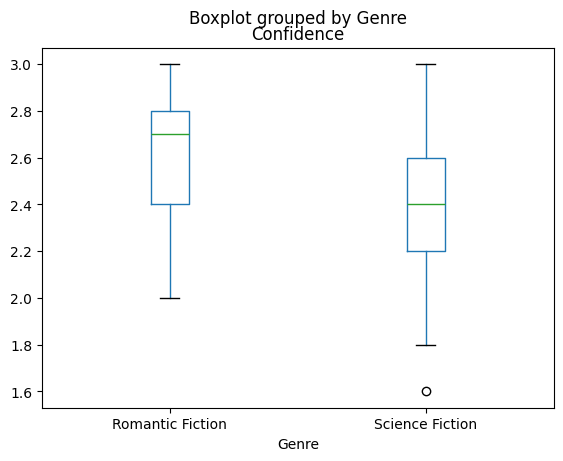

In [37]:
import matplotlib.pyplot as plt

scifi_confidences = []
romantic_confidences = []

for sample in dataset['samples']:
    if sample['genre'] == 'SCI':
        scifi_confidences.append(sample['annotations']['confidence']['average_confidence'])
    if sample['genre'] == 'ROM':
        romantic_confidences.append(sample['annotations']['confidence']['average_confidence'])

genre_df = pd.DataFrame({
    'Genre': ['Science Fiction'] * len(scifi_confidences) + ['Romantic Fiction'] * len(romantic_confidences),
    'Confidence': scifi_confidences + romantic_confidences
})

genre_df.boxplot(by='Genre', column='Confidence', grid=False)


This shows a remarkable difference in the average confidence levels between the two genres. Let's see if this is something that's spread equally across annotators by plotting the confidence levels per genre individually:

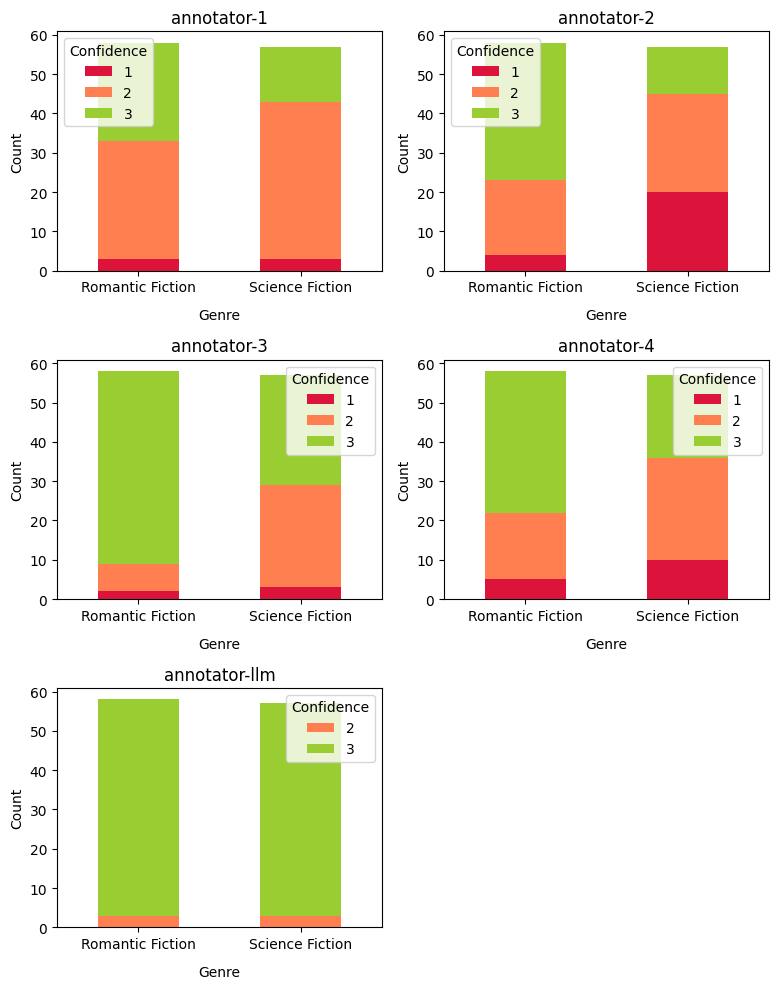

In [38]:

# Map confidence levels to ordinal values
confidence_map = {
    1: 'Not confident',
    2: 'Somewhat confident',
    3: 'Confident'
}

# Per annotator
genre_conf_per_annotator = {}
for annotator in ['annotator-1', 'annotator-2', 'annotator-3', 'annotator-4', 'annotator-llm']:
    scifi_confidences = []
    romantic_confidences = []
    for sample in dataset['samples']:
        if sample['genre'] == 'SCI':
            scifi_confidences.append(sample['annotations']['confidence'][annotator])
        if sample['genre'] == 'ROM':
            romantic_confidences.append(sample['annotations']['confidence'][annotator])

    genre_df = pd.DataFrame({
        'Genre': ['Science Fiction'] * len(scifi_confidences) + ['Romantic Fiction'] * len(romantic_confidences),
        'Confidence': scifi_confidences + romantic_confidences
    })

    key = genre_df['Confidence'].map(confidence_map)

    genre_df.iloc[key.argsort()]
    
    genre_conf_per_annotator[annotator] = genre_df

# Define colors for each confidence level
confidence_colors = {
    1: 'crimson',
    2: 'coral',
    3: 'yellowgreen'
}

# Plot the confidence levels per annotator in a bar chart with specified colors
fig, axs = plt.subplots(3, 2, figsize=(8, 10))

for i, annotator in enumerate(genre_conf_per_annotator.keys()):
    ax = axs[i // 2, i % 2]
    # Extract the genre and confidence data for plotting
    data_to_plot = genre_conf_per_annotator[annotator].groupby(['Genre', 'Confidence']).size().unstack()
    # Map the confidence to the predefined colors
    colors = [confidence_colors[conf] for conf in data_to_plot.columns]
    data_to_plot.plot(kind='bar', ax=ax, stacked=True, color=colors)
    ax.set_title(annotator)
    ax.set_ylabel('Count')
    ax.set_xlabel('Genre')
    ax.legend(title='Confidence')
    # Make the x-labels horizontal
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    # Increase padding between x-axis and labels
    ax.xaxis.labelpad = 10

# Increase space between plots
plt.tight_layout()

# Remove final empty plot if number of annotators is odd
if len(genre_conf_per_annotator.keys()) % 2 != 0:
    fig.delaxes(axs[-1, -1])



Huh, it seems that the LLM Annotator is generally very confident, making the actual difference in confidence levels between genre appear even smaller than it actually is between just the human annotators. Let's redraw the first graph but specify that it's just the human annotators.

<Axes: title={'center': 'Confidence'}, xlabel='Genre', ylabel='Average Confidence'>

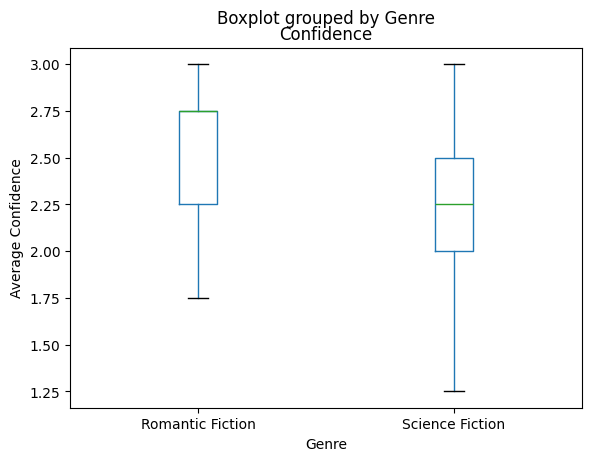

In [42]:
# Repeat but skip annotator-llm
scifi_confidences = []
romantic_confidences = []

for sample in dataset['samples']:
    if sample['genre'] == 'SCI':
        sum_confidence = 0
        count = 0
        # Skip annotator-llm and recalculate average confidence
        for annotator in ['annotator-1', 'annotator-2', 'annotator-3', 'annotator-4']:
            if sample['annotations']['confidence'][annotator] is not None:
                sum_confidence += sample['annotations']['confidence'][annotator]
                count += 1
        if count > 0: # Avoid division by zero
            scifi_confidences.append(sum_confidence / count)
    if sample['genre'] == 'ROM':
        sum_confidence = 0
        count = 0
        # Skip annotator-llm and recalculate average confidence
        for annotator in ['annotator-1', 'annotator-2', 'annotator-3', 'annotator-4']:
            if sample['annotations']['confidence'][annotator] is not None:
                sum_confidence += sample['annotations']['confidence'][annotator]
                count += 1
        if count > 0: # Avoid division by zero
            romantic_confidences.append(sum_confidence / count)


genre_df = pd.DataFrame({
    'Genre': ['Science Fiction'] * len(scifi_confidences) + ['Romantic Fiction'] * len(romantic_confidences),
    'Confidence': scifi_confidences + romantic_confidences
})

genre_df.boxplot(by='Genre', grid=False, ylabel='Average Confidence', xlabel='Genre')



Done. We have successfully:

1. Annotated a dataset of sentences with understatements using a LLM.
2. Loaded human annotations
3. Calculated Inter-Annotator Agreement metrics.
4. Created a corpus of understatement annotations, complete with Inter-Annotator Agreement metrics and genre labels.
5. Compared the genres to see how these affected annotator confidence.